In [1]:
def evaluate(battery_swap_schedule):
    total_travel_time = 0
    total_waiting_time = 0
    battery_urgency_score = 0
    active_fleet_batery_score = 0
    total_battery_cycle = 0
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            total_travel_time += sched["travel_time"]
            total_waiting_time += sched["waiting_time"]
            battery_urgency_score += ((100 - sched["exchanged_battery"]) ** 2)
            active_fleet_batery_score += (sched["received_battery"] ** 2)
            total_battery_cycle += sched["received_battery_cycle"]
        elif sched:
            active_fleet_batery_score += sched["battery_now"]
    if total_travel_time or total_waiting_time:
        total_score = (battery_urgency_score + active_fleet_batery_score) / ((total_travel_time + (10 * total_waiting_time))/60 + total_battery_cycle/8)
    else:
        total_score = battery_urgency_score + active_fleet_batery_score

    return total_score

In [2]:
import copy
import random

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []

    # 1. Masukkan jadwal tetap (dari ev['swap_schedule']) dulu ke slot_timeline
    # Kumpulkan semua jadwal tetap dari ev['swap_schedule']
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    # Urutkan setiap antrian berdasarkan arrival_time
    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    # 2. Kumpulkan EV dari solusi yang assigned, tapi hanya yang tidak punya jadwal tetap
    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    # 3. Urutkan berdasarkan arrival_time (yang datang duluan diproses lebih dulu)
    swaps.sort()

    # 4. Proses masing-masing EV, hitung ulang waiting_time dan received_battery
    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        # Update ke dalam solution
        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        # Tambahkan ke slot_timeline untuk update antrian selanjutnya
        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution



def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    # Inisialisasi semua EV yang punya schedule tetap
    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    # Ambil EV yang layak dijadwalkan
    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue
        energy_to_nearest = min(data['energy_distance'])
        if data['battery_now'] - energy_to_nearest < threshold:
            candidates.append(i)

    # Acak urutan EV
    random.shuffle(candidates)

    # Jadwalkan secara acak ke slot kosong
    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if data['battery_now'] - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'received_battery_cycle': None
            }
            continue

        # Pilih slot acak dari opsi valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        exchanged_battery = data['battery_now'] - energy_dist

        solution[i] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang waiting_time dan received_battery
    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution


In [3]:
import copy
import random
import numpy as np
import math

def get_neighbor(solution, ev, battery_swap_station, charging_rate, threshold=15, required_battery_threshold=80):
    neighbor = copy.deepcopy(solution)

    # Ambil daftar EV yang assigned di solution tetapi tidak punya swap_schedule tetap di ev
    movable_ev_ids = [
        ev_id for ev_id in neighbor
        if neighbor[ev_id] and neighbor[ev_id].get("assigned") and not ev[ev_id].get("swap_schedule")
    ]

    if not movable_ev_ids:
        return neighbor  # Tidak ada yang bisa diubah

    # Pilih satu EV secara acak dari yang bisa diubah
    ev_id = random.choice(movable_ev_ids)
    data = ev[ev_id]

    # Cari opsi stasiun-slot valid untuk EV ini
    valid_options = []
    for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
        if data['battery_now'] - ed < 0:
            continue
        for slot_idx in range(len(battery_swap_station[station_idx])):
            valid_options.append((station_idx, slot_idx, ed, tt))

    if not valid_options:
        # Jika tidak ada opsi valid, set jadi unassigned
        neighbor[ev_id] = {
            'assigned': False,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': None,
            'slot': None,
            'energy_distance': None,
            'travel_time': None,
            'waiting_time': None,
            'exchanged_battery': None,
            'received_battery': None,
            'received_battery_cycle': None
        }
    else:
        # Acak salah satu pilihan valid
        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        exchanged_battery = data['battery_now'] - energy_dist
        neighbor[ev_id] = {
            'assigned': True,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,  # akan diupdate
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,  # akan diupdate
            'received_battery_cycle': 0 # akan diupdate
        }

    # Update ulang nilai waiting_time dan received_battery setelah perubahan
    neighbor = queue_update(neighbor, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return neighbor

def crossover(parent1, parent2, ev, battery_swap_station, charging_rate):
    child = {}
    for ev_id in parent1:
        if random.random() < 0.5:
            child[ev_id] = copy.deepcopy(parent1[ev_id])
        else:
            child[ev_id] = copy.deepcopy(parent2.get(ev_id, parent1[ev_id]))
    return queue_update(child, ev, battery_swap_station, charging_rate)

def genetic_algorithm_strategy(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    population_size=50,
    generations=100,
    crossover_rate=0.8,
    mutation_rate=0.2,
    elitism=True
):
    # 1. Initialization
    population = [random_initialization(battery_swap_station, ev, threshold, charging_rate) for _ in range(population_size)]
    scores = [evaluate(indiv) for indiv in population]
    best_solution = copy.deepcopy(population[np.argmax(scores)])
    best_score = max(scores)

    for generation in range(generations):
        new_population = []

        # Elitism: retain best individual
        if elitism:
            elite = copy.deepcopy(best_solution)
            new_population.append(elite)

        while len(new_population) < population_size:
            # 2. Selection: tournament of 2
            i1, i2 = random.sample(range(population_size), 2)
            p1 = population[i1] if scores[i1] > scores[i2] else population[i2]

            i3, i4 = random.sample(range(population_size), 2)
            p2 = population[i3] if scores[i3] > scores[i4] else population[i4]

            # 3. Crossover
            if random.random() < crossover_rate:
                child = crossover(p1, p2, ev, battery_swap_station, charging_rate)
            else:
                child = copy.deepcopy(p1)

            # 4. Mutation
            if random.random() < mutation_rate:
                child = get_neighbor(child, ev, battery_swap_station, charging_rate, threshold)

            new_population.append(child)

        # 5. Evaluation
        population = new_population
        scores = [evaluate(indiv) for indiv in population]
        max_gen_score = max(scores)
        if max_gen_score > best_score:
            best_score = max_gen_score
            best_solution = copy.deepcopy(population[np.argmax(scores)])

        print(f"Gen {generation+1}: Best Score = {round(best_score, 4)}")

    return best_solution, best_score


In [7]:
import random
import pickle

with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

print(battery_swap_station_demo, ev_demo)

best_solution, best_score = genetic_algorithm_strategy(
    battery_swap_station_demo,
    ev_demo,
    threshold=15,
    charging_rate=100/240,
    population_size=50,
    generations=100,
    crossover_rate=0.8,
    mutation_rate=0.2
)

print(best_solution)
print(best_score)

[[[5, 17], [25, 33]], [[3, 15], [27, 34]], [[2, 17], [25, 32]], [[2, 20], [25, 35]], [[4, 14], [25, 34]], [[7, 12], [27, 32]], [[10, 16], [23, 33]], [[9, 13], [23, 35]], [[8, 16], [24, 38]], [[5, 19], [27, 32]]] {0: {'battery_now': 80, 'battery_cycle': 30, 'energy_distance': [12, 28, 30, 14, 13, 31, 12, 20, 16, 34], 'travel_time': [27, 15, 13, 22, 36, 26, 16, 39, 36, 16], 'swap_schedule': {'assigned': True, 'battery_now': 80, 'battery_cycle': 30, 'battery_station': 3, 'slot': 0, 'energy_distance': 14, 'travel_time': 22, 'waiting_time': 8, 'exchanged_battery': 66, 'received_battery': 100, 'received_battery_cycle': 35}}, 1: {'battery_now': 91, 'battery_cycle': 60, 'energy_distance': [37, 21, 31, 28, 18, 17, 40, 23, 37, 13], 'travel_time': [38, 19, 12, 38, 37, 18, 11, 28, 13, 11], 'swap_schedule': {}}, 2: {'battery_now': 77, 'battery_cycle': 63, 'energy_distance': [39, 34, 23, 40, 17, 13, 30, 13, 40, 25], 'travel_time': [17, 36, 16, 40, 20, 35, 20, 24, 22, 27], 'swap_schedule': {}}, 3: {'

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    """
    Run the Simulated Annealing algorithm multiple times and plot distributions of 
    both fitness values and computation times.
    
    Parameters:
    - initial_temp: Initial temperature
    - num_of_cycle: Number of cycles after which temperature becomes 0
    - runs: Number of independent runs
    - max_attempts: Maximum number of attempts to find a valid solution
    
    Returns:
    - mean_fitness: Mean fitness across all valid runs
    - std_fitness: Standard deviation of fitness across all valid runs
    - mean_duration: Mean computation time across all runs (in seconds)
    - std_duration: Standard deviation of computation time across all runs (in seconds)
    """
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of simulated annealing...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()
        
        solution, fitness = genetic_algorithm_strategy(
            battery_swap_station_demo,
            ev_demo,
            threshold=15,
            charging_rate=100/240,
            population_size=50,
            generations=100,
            crossover_rate=0.8,
            mutation_rate=0.2
        )
        
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    # Print summary
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    # 1. PLOT FITNESS DISTRIBUTION
    if fitness_values:
        # Calculate fitness statistics
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        # Plot fitness distribution
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    # 2. PLOT DURATION DISTRIBUTION
    if duration_values:
        # Calculate duration statistics
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)
        
        # Plot duration distribution
        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration


Running 100 trials of simulated annealing...
Gen 1: Best Score = 193.2537
Gen 2: Best Score = 193.2537
Gen 3: Best Score = 193.2537
Gen 4: Best Score = 193.2537
Gen 5: Best Score = 194.1373
Gen 6: Best Score = 194.1373
Gen 7: Best Score = 194.1373
Gen 8: Best Score = 194.1373
Gen 9: Best Score = 194.1373
Gen 10: Best Score = 194.2622
Gen 11: Best Score = 194.9338
Gen 12: Best Score = 195.0743
Gen 13: Best Score = 195.0743
Gen 14: Best Score = 195.0743
Gen 15: Best Score = 195.0743
Gen 16: Best Score = 195.0743
Gen 17: Best Score = 195.0743
Gen 18: Best Score = 195.4206
Gen 19: Best Score = 195.4206
Gen 20: Best Score = 195.9586
Gen 21: Best Score = 196.2081
Gen 22: Best Score = 196.2081
Gen 23: Best Score = 196.8221
Gen 24: Best Score = 196.8221
Gen 25: Best Score = 197.4307
Gen 26: Best Score = 197.4307
Gen 27: Best Score = 198.1853
Gen 28: Best Score = 198.1853
Gen 29: Best Score = 198.1853
Gen 30: Best Score = 198.1853
Gen 31: Best Score = 198.1853
Gen 32: Best Score = 198.5671
Gen 

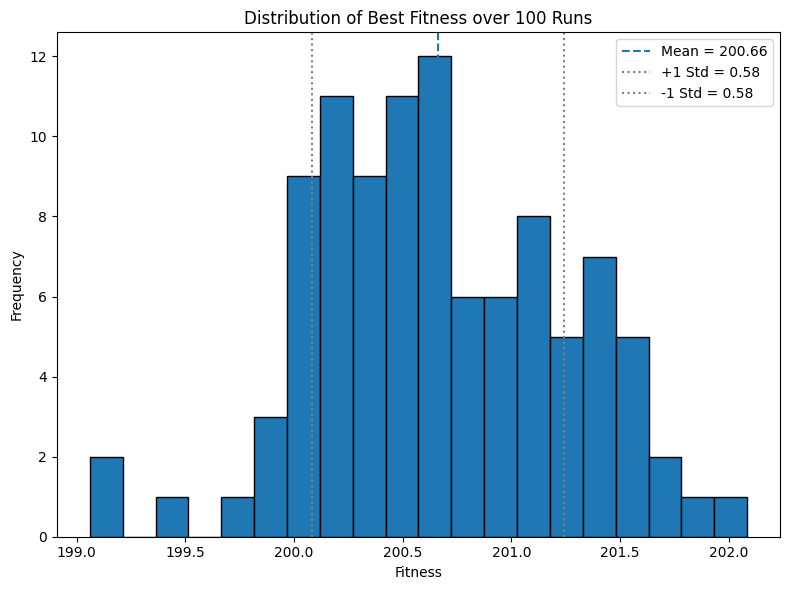

Mean fitness: 200.6626
Std deviation of fitness: 0.5784


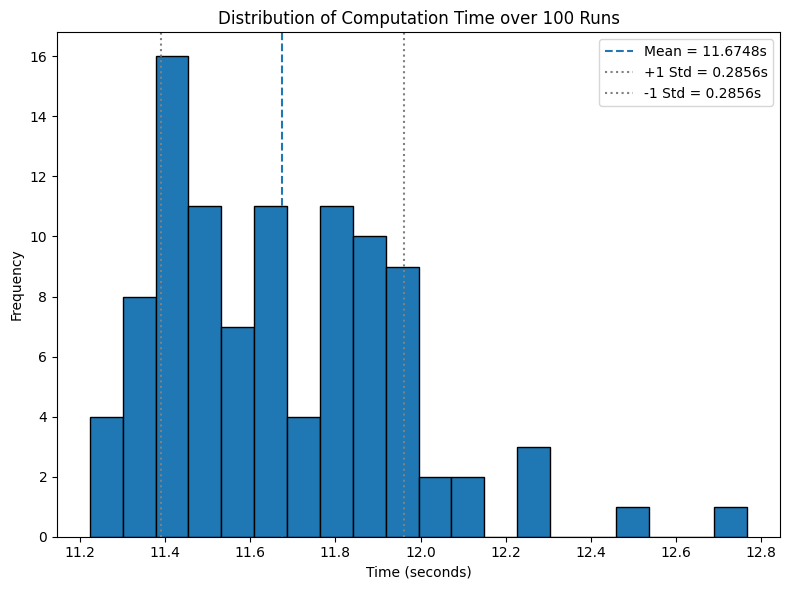

Mean computation time: 11.6748 seconds
Std deviation of time: 0.2856 seconds


(np.float64(200.66257547861588),
 np.float64(0.5783745060179378),
 np.float64(11.67484938621521),
 np.float64(0.28558066197803417))

In [11]:
plot_distributions(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)